# Traffic Light Classification and Detection

In this script, we'll classify and detect the traffic light with a bundled CaffeNet model.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
#set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#display plots in this notebook
%matplotlib inline

#set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

/home/frg/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '/home/frg/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### 2. Load net and set up input preprocessing

* Set Caffe to CPU or GPU mode and load the net from disk.

In [3]:
caffe.set_mode_gpu()

model_def = 'model/deploy.prototxt'
model_weights = 'model/0_iter_106500.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [4]:
# load the mean file for subtraction
mu = np.load('model/mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 70.876203623716719), ('G', 71.06222782417899), ('R', 67.818388415267691)]


### 3. classification

* Now ready to perform classification. 

* Load images and perform the preprocessing we've set up.

images/a5af6bd86cf1ee6a2ce4a539ace787f8.jpg


(-0.5, 454.5, 255.5, -0.5)

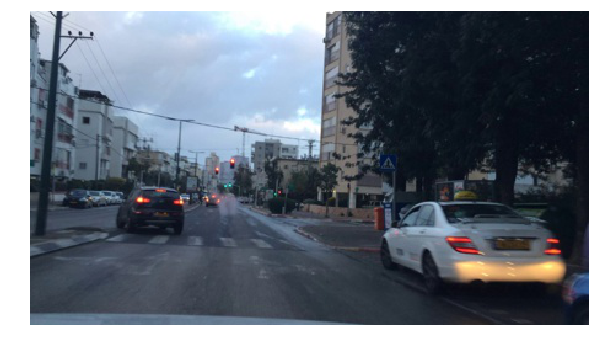

In [5]:
#f = 'images/0bc85042878d4d63454403f68fee11b9.jpg'
#f = 'images/0db0c337db0a3a4df796e9eafa6c02ed.jpg'
#f = 'images/4daea741d48639d20288955ae299d1e0.jpg'
#f = 'images/6a7aac7ea5435a53d8c5644a5c17fde1.jpg'
#f = 'images/8f91ad839076f24d6a0e27029f07d2c0.jpg'
f = 'images/a5af6bd86cf1ee6a2ce4a539ace787f8.jpg'
print f
image = caffe.io.load_image(f)

transformed_image = transformer.preprocess('data', image)
sizechanged_img = transformer.deprocess('data',transformed_image) 
plt.imshow(image)
plt.axis('off') 

* Then we can classify it!

In [6]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the image
cls = output_prob.argmax()

# load labels
labels = ['none', 'red', 'green']
print 'predicted class is:', labels[cls]
print 'none probability:', output_prob[0]
print 'red probability:', output_prob[1]
print 'green probability:', output_prob[2]

predicted class is: red
none probability: [[ 0.22320031]]
red probability: [[ 0.63235414]]
green probability: [[ 0.14444546]]


* The net gives us the predicted class and a vector of probabilities

### 5. Let's detect where is the traffic light

* mainly refer to 'Deep Inside Convolutional Networks Visualising Image Classification Models and Saliency Maps'

* Here are several functions

In [7]:
# when flag==0, show salience_map only, when flag==1, show img+salience_map
def drawit ( salience_map, image, flag):    
    if flag == 0:
        plt.imshow(salience_map,cmap=cm.jet)
        plt.axis('off') 
    else:
        plt.imshow(image, alpha = 0.8)
        plt.imshow(salience_map,cmap=cm.jet, alpha = 0.5)    
        plt.axis('off') 
        
# scale the salience_map   
def scaleit (salience_map):
    salience_map -= salience_map.min()
    salience_map /= salience_map.max()
    return salience_map

# search for the position of traffic light
def searchit(salience_map, sizechanged_img):    
    row, column = salience_map.shape
    temp = np.zeros([row*column])
    for i in range(row):
        temp[i*column:(i+1)*column] =  salience_map[i, :]
    positions = np.argsort(-temp)
    H = np.zeros([20])
    for i in range(20):
        H[i] = sizechanged_img[divmod(positions[i], column)][cls-1]/sizechanged_img[divmod(positions[i], column)].sum()
    position = positions[np.argmax(H)]
    m, n = divmod(position, column)  
    return m,n

# sign the position of traffic light with '+'
def signit (image ,m ,n , cls):    
    row, column, depth = image.shape
    m = m * row /227
    n = n*column /227
    l = 10
    if m<l:
        rowstart = 0
        rowend = m+l
    elif m>row-l:
        rowstart = m-l
        rowend = row
    else:
        rowstart = m-l
        rowend = m+l      
    rowstep =rowend -rowstart+1
    if n<l:
        columnstart = 0
        columnend = n+l
    elif n>column-l:
        columnstart = n-l
        columnend = column
    else:
        columnstart = n-l
        columnend = n+l
    columnstep =columnend -columnstart+1
    if cls == 1:
        image[rowstart:rowend+1, n,0] = np.ones([rowstep])
        image[rowstart:rowend+1, n,1] = np.zeros([rowstep])
        image[rowstart:rowend+1, n,2] = np.zeros([rowstep])
        image[m, columnstart:columnend+1,0] = np.ones([ columnstep])
        image[m, columnstart:columnend+1,1] = np.zeros([ columnstep])
        image[m, columnstart:columnend+1,2] = np.zeros([ columnstep])
    else:
        image[rowstart:rowend+1, n,0] = np.zeros([rowstep])
        image[rowstart:rowend+1, n,1] = np.ones([rowstep])
        image[rowstart:rowend+1, n,2] = np.zeros([rowstep])
        image[m, columnstart:columnend+1,0] = np.zeros([ columnstep])
        image[m, columnstart:columnend+1,1] = np.ones([ columnstep])
        image[m, columnstart:columnend+1,2] = np.zeros([ columnstep])
        
    return image

* compute the salience_map

In [8]:
caffe.set_mode_gpu()

model_def = 'model/deploy_BW.prototxt'

BackwardNet = caffe.Net(model_def, model_weights, caffe.TEST)     
BackwardNet.params['score'][0].data[...] = np.zeros(BackwardNet.params['score'][0].data.shape)
BackwardNet.params['score'][1].data[...] = np.zeros(BackwardNet.params['score'][1].data.shape)
BackwardNet.params['score'][0].data[:,cls] = 1

BackwardNet_img = transformed_image.reshape([1] + [transformed_image.shape[i] for i in range(3)]) 

Backward_fw = BackwardNet.forward(data = BackwardNet_img)
Backward_bw = BackwardNet.backward(score = BackwardNet.blobs['score'].data)

layer_name ='data'
diff = BackwardNet.blobs[layer_name].diff
diff = diff[0].transpose(1,2,0) #for example: (1, 3, 227, 227) to (227, 227, 3)
diff = np.abs(diff).max(2) #for example: (227, 227,3) to (227, 227)
salience_map = diff
salience_map = scaleit (salience_map) 


* show the salience map if there is a traffic light

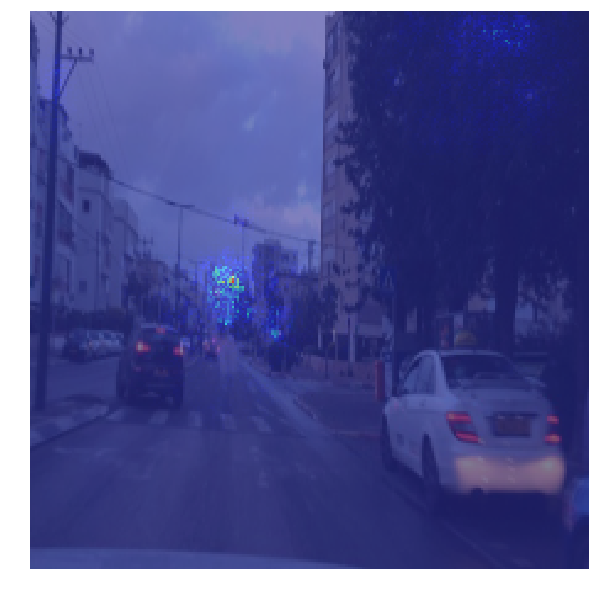

In [9]:
if cls != 0:
    drawit (salience_map, sizechanged_img, 1)

* sign the traffic light in the original image if there is a traffic light

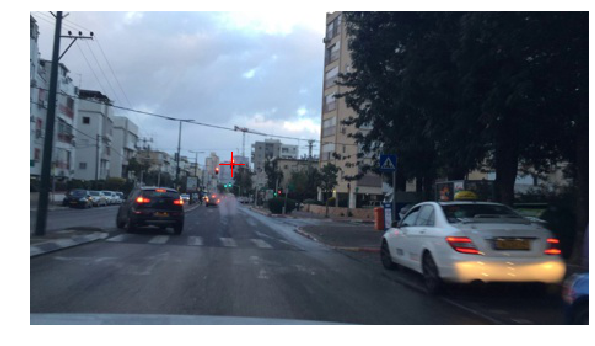

In [10]:
if cls != 0:
    m, n = searchit(salience_map, sizechanged_img)
    signit (image ,m ,n , cls)
    plt.imshow(image)
    plt.axis('off') 